#  **Setup and checks**





In [29]:
import tensorflow as tf
if tf.__version__!="2.0.0-beta1":
  !pip install --upgrade tensorflow-gpu==2.0.0b1
  print("updated Tensorflow library")
import os
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import random
import tensorflow_datasets as tfds


assert tf.__version__=="2.0.0-beta1", "Upgrade tf, then restart runtime"
assert tf.test.is_gpu_available(), "Connect GPU"

keras = tf.keras

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

os.chdir("/content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia")
!pwd &ls

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia
 chest_xray
 chest_xray_dataset
'Copy of ResNet.ipynb'
 Data_exploration.ipynb
 hello_test.txt
 inception_log.txt
 inception_v3_model.h5
 main_inception_incremental.ipynb
 main_inception.ipynb
 main.ipynb
 main_ResNet.ipynb
 Models_ensemble.ipynb
 Paper
 Prepare_Kaggle.ipynb
 ResNet.ipynb
 resnet_train_cache.tf-data_0.data-00000-of-00001.tempstate476731692081975760
 resnet_train_cache.tf-data_0.lockfile
 resnet_val_cache.tf-data_0.data-00000-of-00001.tempstate8465232386454851418
 resnet_val_cache.tf-data_0.lockfile
 saved_model_latest.h5
 saved_model_latest_hyperparameters_tweaking.h5
 training_log.txt




# Load data:
All images will be resized to IMG_SIZE x IMG_SIZE,  and input channels rescaled to a range of [-1,1].


In [3]:
IMG_SIZE = 256 # All images will be resized to this size
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 32
num_train, num_val, num_test = 5216, 16, 624
count = 16
SPLIT_PRECETNTAGE = 0.9

DATA_ROOT = "/content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia"
DATA_ROOT = pathlib.Path(DATA_ROOT)


ALL_LOC = pathlib.Path(str(DATA_ROOT) + '/chest_xray/train')
all_imgs_paths = list(ALL_LOC.glob('*/*.jpeg'))
all_imgs_paths = [str(path) for path in all_imgs_paths]
random.shuffle(all_imgs_paths)

label_names = sorted(item.name for item in ALL_LOC.glob('*/') if item.is_dir())
label_to_index = dict((name, index) for index, name in enumerate(label_names))

all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_imgs_paths]
""
image_count = len(all_imgs_paths)
split_edge = round(image_count * SPLIT_PRECETNTAGE)

train_paths, train_labels = all_imgs_paths[:split_edge], all_image_labels[:split_edge]
val_paths, val_labels =all_imgs_paths[split_edge:], all_image_labels[split_edge:] 

print(len(train_paths), len(val_paths), len(all_imgs_paths))

for i in range(5):
  print(train_labels[i], train_paths[i])

####################################################################################################
TEST_LOC = pathlib.Path(str(DATA_ROOT) + '/chest_xray/test')
test_imgs_paths = list(TEST_LOC.glob('*/*.jpeg'))
test_imgs_paths = [str(path) for path in test_imgs_paths]
random.shuffle(test_imgs_paths)

test_label_names = sorted(item.name for item in TEST_LOC.glob('*/') if item.is_dir())
test_label_to_index = dict((name, index) for index, name in enumerate(test_label_names))

test_image_labels = [test_label_to_index[pathlib.Path(path).parent.name]
                    for path in test_imgs_paths]
""
test_image_count = len(test_imgs_paths)

test_paths, test_labels = test_imgs_paths, test_image_labels

print("\nTrain images are %d image, but Test images are %d." % (len(train_paths), len(test_paths)))


for i in range(5):
  print(test_labels[i], test_paths[i])


4694 522 5216
1 /content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia/chest_xray/train/PNEUMONIA/person816_bacteria_2727.jpeg
1 /content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia/chest_xray/train/PNEUMONIA/person974_virus_1649.jpeg
1 /content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia/chest_xray/train/PNEUMONIA/person1458_virus_2501.jpeg
1 /content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia/chest_xray/train/PNEUMONIA/person3_bacteria_10.jpeg
1 /content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia/chest_xray/train/PNEUMONIA/person1093_bacteria_3033.jpeg

Train images are 4694 image, but Test images are 624.
1 /content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia/chest_xray/test/PNEUMONIA/person143_bacteria_687.jpeg
1 /content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia/chest_xray/test/PNEUMONIA/person109_bacteria_522.jpeg
0 /content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_p

In [0]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = image/127.5 -1 # normalize to [-1,1] range

  return image

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

def show_patient(img, label):
  img = img.numpy()
  print(img.shape)
  fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
  fig.suptitle(label_names[label].title(), fontsize=24)
#   plt.subplots_adjust(hspace=0.1, top=0.1, bottom=0.05)
  for i, ax in enumerate(axs.flat):
      ax.imshow(img[...,i], "gray")
  plt.show()
    
test_path = '/content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia/chest_xray_dataset/NORMAL/NORMAL2-IM-1109-0001.jpeg'
label = 0

# plt.imshow(load_and_preprocess_image(test_path))
# plt.grid(False)
# plt.xlabel("TEST")
# plt.title(label_names[label].title())
# print()

# img = load_and_preprocess_image(test_path)
# show_patient(img, label)



In [0]:
""" Building a dataset """


ds_train = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = ds_train.map(load_and_preprocess_from_path_label)

train_ds = train_ds.shuffle(buffer_size=500)
train_ds = train_ds.repeat()
training_batches = train_ds.batch(BATCH_SIZE)

ds_val = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = ds_val.map(load_and_preprocess_from_path_label)

validation_batches = val_ds.cache() # filename='./resnet_val_cache.tf-data'
validation_batches = validation_batches.batch(BATCH_SIZE)#.prefetch(1)

ds_test = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds = ds_test.map(load_and_preprocess_from_path_label)

test_batches = test_ds.batch(BATCH_SIZE)#.prefetch(1)

In [6]:
'''
i, k = 0, 0
for img_batch, labels in validation_batches.take(16):
  print(i)
  labels = labels.numpy()
  print(labels)
  for img, label in zip(img_batch, labels):
#     show_patient(img, label)
    print('\t',k)
    k+=1
  i+=1
  k=0
'''

"\ni, k = 0, 0\nfor img_batch, labels in validation_batches.take(16):\n  print(i)\n  labels = labels.numpy()\n  print(labels)\n  for img, label in zip(img_batch, labels):\n#     show_patient(img, label)\n    print('\t',k)\n    k+=1\n  i+=1\n  k=0\n"

In [7]:
baseModel = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                           include_top=False,
                                           weights='imagenet')
baseModel.trainable = False
print(len(baseModel.layers))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 4s 0us/step
175


In [8]:
baseModel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

dense_layer = keras.layers.Dense(128)

prediction_layer = keras.layers.Dense(2)



# > **Now building and compiling our model:**

1.   Stacking baseModel with the classifier head.
2.   Compiling the model.




In [0]:
train_new_model = True
if(train_new_model == True):
  model = tf.keras.Sequential([
                              baseModel,
                              global_average_layer,
#                               dense_layer,
                              prediction_layer
                              ])
else:
  model = tf.keras.models.load_model('./inception_v3_model.h5')



In [11]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.SGD(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________




# Train the last two layers of the model:
baseModel is frozen, only the added classifier head is being trained.



In [12]:
print(test_batches.take(1))

<TakeDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>


In [13]:
# num_train, num_val, num_test = 5216, 16, 624

validation_steps = 5

no_epochs = 10
steps_per_epoch=tf.math.ceil(len(all_imgs_paths)/BATCH_SIZE).numpy()

loss0,accuracy0 = model.evaluate(test_batches, steps = 5) #validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


5/5 [==============================] - 60s 12s/step - loss: 6.1991 - accuracy: 0.3688
initial loss: 6.20
initial accuracy: 0.37


In [14]:
print(model.fit.__doc__)

Trains the model for a fixed number of epochs (iterations on a dataset).

    Arguments:
        x: Input data. It could be:
          - A Numpy array (or array-like), or a list of arrays
            (in case the model has multiple inputs).
          - A TensorFlow tensor, or a list of tensors
            (in case the model has multiple inputs).
          - A dict mapping input names to the corresponding array/tensors,
            if the model has named inputs.
          - A `tf.data` dataset or a dataset iterator. Should return a tuple
            of either `(inputs, targets)` or
            `(inputs, targets, sample_weights)`.
          - A generator or `keras.utils.Sequence` returning `(inputs, targets)`
            or `(inputs, targets, sample weights)`.
        y: Target data. Like the input data `x`,
          it could be either Numpy array(s) or TensorFlow tensor(s).
          It should be consistent with `x` (you cannot have Numpy inputs and
          tensor targets, or inverse

In [15]:
history = model.fit(training_batches,
                    epochs=30, #no_epochs,
                    validation_data=validation_batches,
                    validation_steps= 5, #validation_steps,
                    steps_per_epoch=5)

Epoch 1/30


W0728 10:58:51.748816 140505698187136 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


5/5 [==============================] - 324s 65s/step - loss: 6.4921 - accuracy: 0.3125 - val_loss: 6.3749 - val_accuracy: 0.2812
Epoch 2/30
5/5 [==============================] - 69s 14s/step - loss: 4.2410 - accuracy: 0.4500 - val_loss: 6.0147 - val_accuracy: 0.2812
Epoch 3/30
5/5 [==============================] - 68s 14s/step - loss: 3.1762 - accuracy: 0.4844 - val_loss: 5.6663 - val_accuracy: 0.2812
Epoch 4/30
5/5 [==============================] - 68s 14s/step - loss: 2.5062 - accuracy: 0.5000 - val_loss: 5.2909 - val_accuracy: 0.2812
Epoch 5/30
5/5 [==============================] - 69s 14s/step - loss: 2.7671 - accuracy: 0.6125 - val_loss: 0.9953 - val_accuracy: 0.2906
Epoch 6/30
5/5 [==============================] - 67s 13s/step - loss: 3.2162 - accuracy: 0.6219 - val_loss: 0.9756 - val_accuracy: 0.2906
Epoch 7/30
5/5 [==============================] - 66s 13s/step - loss: 2.7131 - accuracy: 0.6938 - val_loss: 0.9741 - val_accuracy: 0.2875
Epoch 8/30
5/5 [=====================

In [16]:
model.evaluate(test_batches, steps = validation_steps)

5/5 [==============================] - 2s 473ms/step - loss: 3.1793 - accuracy: 0.5000


[3.1793054580688476, 0.5]



# Fine tune the model:



In [17]:
baseModel.trainable = True

fine_tune_at = 10

# Freeze all the layers before the `fine_tune_at` layer
for layer in baseModel.layers[:fine_tune_at]:
  layer.trainable =  False

model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.SGD(lr=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 23,524,802
Non-trainable params: 67,008
_________________________________________________________________


In [19]:
no_epochs = 100
fine_tune_epochs = 100
total_epochs =  no_epochs + fine_tune_epochs

history_fine = model.fit(training_batches,
                         epochs=total_epochs,
                         initial_epoch = no_epochs,
                         steps_per_epoch = 5,
                         validation_data = validation_batches)


Epoch 101/200
5/5 [==============================] - 24s 5s/step - loss: 0.8633 - accuracy: 0.8438 - val_loss: 4.4139 - val_accuracy: 0.7126
Epoch 102/200
5/5 [==============================] - 18s 4s/step - loss: 0.9626 - accuracy: 0.8188 - val_loss: 4.4139 - val_accuracy: 0.7126
Epoch 103/200
5/5 [==============================] - 18s 4s/step - loss: 0.6264 - accuracy: 0.8687 - val_loss: 4.4139 - val_accuracy: 0.7126
Epoch 104/200
5/5 [==============================] - 18s 4s/step - loss: 0.9759 - accuracy: 0.8562 - val_loss: 4.4139 - val_accuracy: 0.7126
Epoch 105/200
5/5 [==============================] - 18s 4s/step - loss: 0.5398 - accuracy: 0.8469 - val_loss: 4.4139 - val_accuracy: 0.7126
Epoch 106/200
5/5 [==============================] - 18s 4s/step - loss: 0.8310 - accuracy: 0.8625 - val_loss: 4.4139 - val_accuracy: 0.7126
Epoch 107/200
5/5 [==============================] - 18s 4s/step - loss: 0.6602 - accuracy: 0.8469 - val_loss: 4.4139 - val_accuracy: 0.7126
Epoch 108/200

Text(0.5, 0, 'epoch')

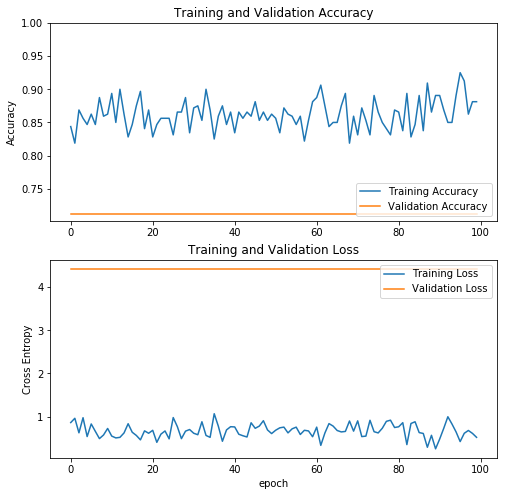

In [20]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

In [21]:
model.evaluate(test_batches, steps = validation_steps)

5/5 [==============================] - 2s 441ms/step - loss: 5.6541 - accuracy: 0.6313


[5.654131889343262, 0.63125]

In [30]:
!pwd

/content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia


In [0]:
model.save('./ResNet_model.h5')

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 23,524,802
Non-trainable params: 67,008
_________________________________________________________________


In [33]:
f = open("ResNet_log.txt", "a")

acc_fine = []
val_acc_fine = []
loss_fine = []
val_loss_fine = []

for i in range(5):
  fine_tune_epochs = 50 #* (i+1)
  no_epochs = 200 + 50 * (i)
  total_epochs =  no_epochs + fine_tune_epochs
  history_fine = model.fit(training_batches,
                         epochs=total_epochs,
                         initial_epoch = no_epochs,
                         steps_per_epoch = 5,
                         validation_data = validation_batches,
                         verbose=2)
  model.save('./ResNet_model.h5')
  
  print("\n\nFinished loop nmber %d\nwith Total epochs of %d\n\n"% (i, total_epochs))
  f.write("%d: Finished a loop\n" % (i))
  f.write("Finished loop nmber %d\nwith Total epochs of %d\n"% (i, total_epochs))

  acc_fine.extend(history_fine.history['accuracy'])
  val_acc_fine.extend(history_fine.history['val_accuracy'])

  loss_fine.extend(history_fine.history['loss'])
  val_loss_fine.extend(history_fine.history['val_loss'])
  

f.close()


Epoch 201/250
5/5 - 24s - loss: 0.5161 - accuracy: 0.8687 - val_loss: 4.4139 - val_accuracy: 0.7126
Epoch 202/250
5/5 - 18s - loss: 0.6807 - accuracy: 0.8406 - val_loss: 4.4139 - val_accuracy: 0.7126
Epoch 203/250
5/5 - 18s - loss: 0.6090 - accuracy: 0.9187 - val_loss: 4.4139 - val_accuracy: 0.7126
Epoch 204/250
5/5 - 18s - loss: 0.6543 - accuracy: 0.8875 - val_loss: 4.4139 - val_accuracy: 0.7126
Epoch 205/250
5/5 - 18s - loss: 0.5611 - accuracy: 0.8844 - val_loss: 4.4139 - val_accuracy: 0.7126
Epoch 206/250
5/5 - 18s - loss: 0.6164 - accuracy: 0.8719 - val_loss: 4.4139 - val_accuracy: 0.7126
Epoch 207/250
5/5 - 17s - loss: 0.6870 - accuracy: 0.8594 - val_loss: 4.4139 - val_accuracy: 0.7126
Epoch 208/250
5/5 - 18s - loss: 0.4400 - accuracy: 0.8969 - val_loss: 4.4139 - val_accuracy: 0.7126
Epoch 209/250
5/5 - 18s - loss: 0.5649 - accuracy: 0.8781 - val_loss: 4.4139 - val_accuracy: 0.7126
Epoch 210/250
5/5 - 17s - loss: 0.7279 - accuracy: 0.8781 - val_loss: 4.4139 - val_accuracy: 0.7126


In [34]:
model.evaluate(test_batches, steps = 5)

5/5 [==============================] - 2s 483ms/step - loss: 5.6541 - accuracy: 0.6313


[5.654131889343262, 0.63125]

Text(0.5, 0, 'epoch')

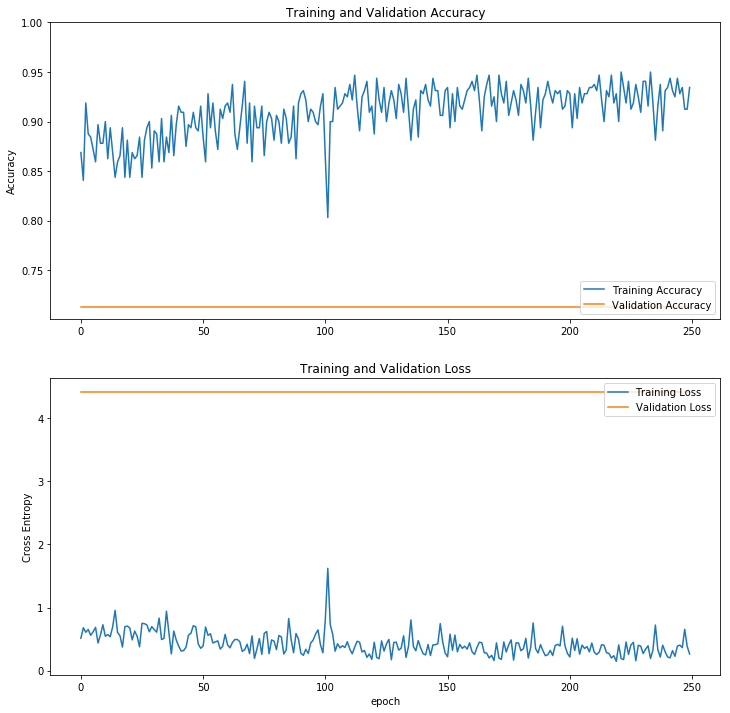

In [35]:
flatten = lambda l: [item for sublist in l for item in sublist]
# x = flatten(list(acc_fine))
# xx = flatten(val_acc_fine)
# y = flatten(loss_fine)
# yy = flatten(val_loss_fine)

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(acc_fine, label='Training Accuracy')
plt.plot(val_acc_fine, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_fine, label='Training Loss')
plt.plot(val_loss_fine, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')